In [1]:
from __future__ import absolute_import, division, print_function # python2 compatibility
import numpy as np
from collections import defaultdict
import os
import time
import configparser

import torch
from torch.utils.data import DataLoader

from training_fns import (parseArguments, weighted_masked_mse_loss, 
                          create_synth_batch, batch_to_cuda, train_synth_iter)
from network import SN_AE
from The_Payne.utils import read_in_neural_network

np.random.seed(1)
torch.manual_seed(1)

# Check for GPU
use_cuda = torch.cuda.is_available()
if use_cuda:
    print('Using GPU!')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    torch.cuda.manual_seed(1)
else:
    torch.set_default_tensor_type('torch.FloatTensor')

In [2]:
# Collect the command line arguments
'''
args = parseArguments()
model_name = args.model_name
verbose_iters = args.verbose_iters
cp_time = args.cp_time
data_dir = args.data_dir
'''
model_name = 'ae_1'
verbose_iters = 10
cp_time = 15
data_dir = 'data/'

# Directories
'''
cur_dir = os.path.dirname(__file__)
'''
cur_dir = ''
config_dir = os.path.join(cur_dir, 'configs/')
model_dir = os.path.join(cur_dir, 'models/')
progress_dir = os.path.join(cur_dir, 'progress/')
'''
if args.data_dir is None:
    data_dir = os.path.join(cur_dir, 'data/')
'''
# Model configuration
config = configparser.ConfigParser()
config.read(config_dir+model_name+'.ini')
architecture_config = config['ARCHITECTURE']
print('\nCreating model: %s'%model_name)
print('\nConfiguration:')
for key_head in config.keys():
    if key_head=='DEFAULT':
        continue
    print('  %s' % key_head)
    for key in config[key_head].keys():
        print('    %s: %s'%(key, config[key_head][key]))
        
# DATA FILES
data_file_obs = os.path.join(data_dir, config['DATA']['data_file_obs'])
spectra_norm_file = os.path.join(data_dir, config['DATA']['spectra_norm_file'])

# TRAINING PARAMETERS
batchsize = int(config['TRAINING']['batchsize'])
learning_rate_encoder = float(config['TRAINING']['learning_rate_encoder'])
learning_rate_decoder = float(config['TRAINING']['learning_rate_decoder'])
loss_weight_x = float(config['TRAINING']['loss_weight_x'])
loss_weight_y = float(config['TRAINING']['loss_weight_y'])
loss_weight_j = float(config['TRAINING']['loss_weight_j'])
total_synth_batch_iters = float(config['TRAINING']['total_synth_batch_iters'])
total_obs_batch_iters = float(config['TRAINING']['total_obs_batch_iters'])
lr_decay_batch_iters = eval(config['TRAINING']['lr_decay_batch_iters'])
lr_decay = float(config['TRAINING']['lr_decay'])


Creating model: ae_1

Configuration:
  DATA
    spectra_norm_file: mean_and_std_PAYNE_specs.npy
    data_file_obs: aspcapStar_dr14.h5
  TRAINING
    batchsize: 4
    learning_rate_encoder: 0.0001
    learning_rate_decoder: 0.0001
    loss_weight_x: 1
    loss_weight_y: 1
    loss_weight_j: 1
    total_synth_batch_iters: 1e6
    total_obs_batch_iters: 1e6
    lr_decay_batch_iters: [20e3, 40e3, 80e3, 120e3, 160e3, 240e3, 400e3]
    lr_decay: 0.7
  ARCHITECTURE
    num_pixels: 7167
    activation: relu
    conv_filts: [32, 64, 128, 256, 512]
    conv_filt_lens: [7, 7, 7, 7, 7]
    conv_strides: [4, 4, 4, 4, 4]
    num_y: 25
    num_z: 4
  Notes
    comment: Original architecture.


In [3]:
# BUILD THE NETWORKS

# Load the Payne pre-trained weights
emulator_coeffs = read_in_neural_network()

# Construct the Auto-encoder
print('\nBuilding networks...')
synth_ae = SN_AE(architecture_config, emulator_coeffs, use_cuda=use_cuda)

# Display model architectures
print('\n\nSYNTHETIC EMULATOR ARCHITECTURE:\n')
print(synth_ae.emulator)
print('\n\nENCODER ARCHITECTURE:\n')
print(synth_ae.encoder)
print('\n\nDECODER ARCHITECTURE:\n')
print(synth_ae.decoder)


Building networks...


SYNTHETIC EMULATOR ARCHITECTURE:

Sequential(
  (0): Linear(in_features=25, out_features=300, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=300, out_features=300, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=300, out_features=7214, bias=True)
)


ENCODER ARCHITECTURE:

Encoder(
  (conv_layers): Sequential(
    (0): Conv1d(1, 32, kernel_size=(7,), stride=(4,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(7,), stride=(4,))
    (3): ReLU()
    (4): Conv1d(64, 128, kernel_size=(7,), stride=(4,))
    (5): ReLU()
    (6): Conv1d(128, 256, kernel_size=(7,), stride=(4,))
    (7): ReLU()
    (8): Conv1d(256, 512, kernel_size=(7,), stride=(4,))
    (9): ReLU()
  )
  (fc_y): Linear(in_features=3072, out_features=25, bias=True)
  (fc_z): Linear(in_features=3072, out_features=4, bias=True)
)


DECODER ARCHITECTURE:

Decoder(
  (fc_in): Linear(in_features=29, out_features=3072, bias=True)
  (conv_layers): Sequential(
    (0): ConvTranspose1d(512, 512,

In [4]:
# Construct optimizer
optimizer = torch.optim.Adam([{'params': synth_ae.encoder.parameters(), "lr": learning_rate_encoder},
                                  {'params': synth_ae.decoder.parameters(), "lr": learning_rate_decoder}],
                                 weight_decay = 0, betas=(0.5, 0.999))
# Learning rate decay
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                                                    milestones=lr_decay_batch_iters, 
                                                    gamma=lr_decay)

In [5]:
# Loss functions
y_loss_fn = torch.nn.MSELoss()
x_loss_fn = weighted_masked_mse_loss

# Check for pre-trained weights
model_filename =  os.path.join(model_dir,model_name+'_synth.pth.tar')
if os.path.exists(model_filename):
    fresh_model = False
else:
    fresh_model = True

In [6]:
# Load pretrained model
if fresh_model:
    print('\nStarting fresh model to train...')
    cur_iter = 1
    losses = defaultdict(list)
else:
    print('\nLoading saved model to continue training...')
    # Load model info
    checkpoint = torch.load(model_filename, map_location=lambda storage, loc: storage)
    cur_iter = checkpoint['batch_iters']+1
    losses = dict(checkpoint['losses'])
    
    # Load optimizer states
    optimizer.load_state_dict(checkpoint['optimizer'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    
    # Load model weights
    synth_ae.load_state_dict(checkpoint['synth_ae'])


Starting fresh model to train...


In [7]:
# Normalization data for the spectra
x_mean, x_std = np.load(spectra_norm_file)

# Load the Payne labels

# [ Teff, Logg, Vturb [km/s],
# [C/H], [N/H], [O/H], [Na/H], [Mg/H],
# [Al/H], [Si/H], [P/H], [S/H], [K/H],
# [Ca/H], [Ti/H], [V/H], [Cr/H], [Mn/H],
# [Fe/H], [Co/H], [Ni/H], [Cu/H], [Ge/H],
# C12/C13, Vmacro [km/s] ]
labels_payne = np.load(data_dir+'mock_all_spectra_no_noise_resample_prior_large.npz')['labels'].T

# Perturb the payne labels within a range to create our synthetic training batches.
# These perturbations are in the same order as the labels.
perturbations = [100., 0.1, 0.2, *np.repeat(0.1, 20), 5., 2.]

# Calculate the matrix that will be applied to our "reference" labels
# to evaluate our gradients throughout training.
dy = torch.Tensor(np.array([[25., 0.025, 0.05, *np.repeat(0.025, 20), 1.25, 0.5]]).astype(np.float32))

# J_mean and J_std are used to re-scale the Jacobians for dx/dy in order to give each label 
# roughly equal weighting.
J_mean = torch.tensor([ 2.5398e-02,  3.9143e-03, -6.8804e-03, -1.9135e-02, -1.2382e-02,
                       3.0295e-03,  2.3935e-04,  4.9596e-03,  7.2305e-05,  3.7045e-04,
                       -1.6349e-04, -2.5678e-04,  1.8938e-04, -4.1522e-04, -4.7446e-04,
                       1.9350e-04, -3.7019e-04, -6.2980e-04, -1.0593e-02,  6.8642e-04,
                       -1.3395e-03, -1.3596e-05,  1.4643e-04, -1.0597e-02,  5.5806e-03]).unsqueeze(1)

J_std = torch.tensor([0.0400, 0.0113, 0.0158, 0.0469, 0.0334, 0.0269, 0.0028, 0.0200, 0.0077,
                      0.0159, 0.0011, 0.0037, 0.0007, 0.0068, 0.0062, 0.0016, 0.0040, 0.0105,
                      0.0389, 0.0047, 0.0101, 0.0026, 0.0022, 0.0280, 0.0200]).unsqueeze(1)

# Turn these into matrices that can easily be applied to a batch.
dy_batch = torch.zeros((batchsize*dy.size(1), dy.size(1)))
J_mean_batch = torch.zeros((batchsize*dy.size(1), 1))
J_std_batch = torch.zeros((batchsize*dy.size(1), 1))
for i, indx in enumerate(range(0, dy_batch.size(0), batchsize)):
    dy_batch[indx:indx+batchsize, i] = dy[0,i]
    J_mean_batch[indx:indx+batchsize] = J_mean[i]
    J_std_batch[indx:indx+batchsize] = J_std[i]

In [8]:
def evaluate_dxdy(synth_ae, synth_train_batch, x_mean, x_std, 
                  dy_batch, J_mean_batch, J_std_batch,  use_cuda):

    # Repeat labels into matrix
    y_ref = torch.cat(synth_train_batch['y'].size(1)*[synth_train_batch['y'].clone()])
    # Apply + an - deviations 
    y_pos = y_ref.clone()+dy_batch
    y_neg = y_ref.clone()-dy_batch

    # Produce x_synth using the emulator for + and - 
    x_pos = synth_ae.run_emulator(y_pos)
    x_neg = synth_ae.run_emulator(y_neg)

    # Normalize the spectra
    x_pos = (x_pos - x_mean) / x_std
    x_neg = (x_neg - x_mean) / x_std
    
    # Only select last 7167 pixels
    x_pos = x_pos[:,47:]
    x_neg = x_neg[:,47:]
    
    # Calculate the Jacobian for the emulator
    J_tgt = x_pos - x_neg
    
    # Produce x_synth using the decoder for + and -
    x_pos = synth_ae.yz_to_xsynth(y_pos)
    x_neg = synth_ae.yz_to_xsynth(y_neg)
    
    # Calculate Jacobian for the decoder
    J_dec = x_pos - x_neg
    
    # Normalize to give each label equal weighting
    J_tgt = (J_tgt - J_mean_batch)/J_std_batch
    J_dec = (J_dec - J_mean_batch)/J_std_batch

    j_loss = torch.mean((J_tgt.detach()-J_dec)**2)
    
    return j_loss

In [9]:
def train_synth_iter(synth_ae, synth_train_batch, x_loss_fn, y_loss_fn, 
                     loss_weight_x, loss_weight_y, loss_weight_j, 
                     optimizer, lr_scheduler, losses_cp, cur_iter, 
                     x_mean, x_std, dy_batch, J_mean_batch, J_std_batch, use_cuda,
                    rec_grads):
    
    # RUN MODEL
    
    synth_ae.train_mode()
    # Encoding
    y_synth, z_synth = synth_ae.x_to_yz(synth_train_batch['x'].detach())
    # Decoding
    x_synthsynth = synth_ae.yz_to_xsynth(synth_train_batch['y'].detach())

    # EVALUATE LOSSES
    
    # Targets for y_synth
    y_tgt = (synth_train_batch['y'] - synth_ae.y_min)/(synth_ae.y_max - synth_ae.y_min) - 0.5
    # Targets for z_synth
    z_tgt = torch.zeros((len(synth_train_batch['y']), synth_ae.num_z), dtype=torch.float32)
    print(torch.mean(synth_train_batch['x']), torch.std(synth_train_batch['x']))
    print(torch.mean(x_synthsynth), torch.std(x_synthsynth))
        
    # x to y
    y_loss = y_loss_fn(y_synth, y_tgt)
    # x to z
    z_loss = y_loss_fn(z_synth, z_tgt)
    # y to x
    xsynth_loss = x_loss_fn(pred=x_synthsynth, 
                            target=synth_train_batch['x'], 
                            error=synth_train_batch['x_err'], 
                            mask=synth_train_batch['x_msk'])
    
    # Evaluate the dx/dy Jacobians and compare them to the the Jacobian produced by the emulator
    if rec_grads:
        loss_grads_synth = evaluate_dxdy(synth_ae, synth_train_batch, x_mean, x_std, 
                                         dy_batch, J_mean_batch, J_std_batch,  use_cuda)
    else:
        loss_grads_synth = torch.tensor(np.array([0]).astype(np.float32))
    
    # Combine losses with appropriate loss weights
    loss_total = (loss_weight_y * y_loss + 
                  loss_weight_y * z_loss +
                  loss_weight_x * xsynth_loss +
                  loss_weight_j * loss_grads_synth)

    # Back propogate
    optimizer.zero_grad()
    loss_total.backward()
    # Adjust network weights
    optimizer.step()    
    # Adjust learning rate
    lr_scheduler.step()

    # Save losses
    losses_cp['y_synth'].append(y_loss.data.item())
    losses_cp['z_synth'].append(z_loss.data.item())
    losses_cp['x_synth'].append(xsynth_loss.data.item())
    losses_cp['dxdy_synth'].append(loss_grads_synth.data.item())

    return losses_cp

In [10]:
def train_network(cur_iter):
    print('Training the network...')
    print('Progress will be displayed every %i iterations and the model will be saved every %i minutes.'%
          (verbose_iters,cp_time))
    # Train the neural networks
    losses_cp = defaultdict(list)
    cp_start_time = time.time()
    
    while cur_iter < total_synth_batch_iters:
        
        # Create synthetic batch from the distribution of the original Payne training set.
        synth_train_batch = create_synth_batch(synth_ae, x_mean, x_std, 
                                               batchsize=batchsize,
                                               labels_payne=labels_payne, 
                                               perturbations=perturbations)

        # Switch to GPU
        if use_cuda:
            synth_train_batch = batch_to_cuda(synth_train_batch)

        # Train an iteration
        losses_cp = train_synth_iter(synth_ae, synth_train_batch, x_loss_fn, y_loss_fn, 
                                     loss_weight_x, loss_weight_y, loss_weight_j, 
                                     optimizer, lr_scheduler, losses_cp, cur_iter, 
                                     x_mean, x_std, dy_batch, J_mean_batch, J_std_batch, use_cuda,
                                     rec_grads=True)

        # Display losses
        if cur_iter % verbose_iters == 0:

            # Calculate averages
            for k in losses_cp.keys():
                losses[k].append(np.mean(losses_cp[k]))
            losses['batch_iters'].append(cur_iter)

            # Print current status
            print('\nBatch Iterations: %i/%i ' % (cur_iter, total_synth_batch_iters))
            print('Training Losses:')
            print('\t|   Y_loss   |    X_loss   |   Z_loss   | dXdY_loss |')
            print('Synth   |  %0.5f  |  %0.5f  |  %0.5f  |   %0.5f   |' % 
                  (losses['y_synth'][-1], losses['x_synth'][-1], losses['z_synth'][-1], 
                   losses['dxdy_synth'][-1]))

            print('\n') 

            # Save losses to file to analyze throughout training. 
            np.save(os.path.join(progress_dir, model_name+'_losses.npy'), losses) 
            # Reset checkpoint loss dict
            losses_cp = defaultdict(list)
            # Free some GPU memory
            torch.cuda.empty_cache()

        # Increase the iteration
        cur_iter += 1

        # Save periodically
        if time.time() - cp_start_time >= cp_time*60:
            print('Saving network...')

            torch.save({'batch_iters': cur_iter,
                        'losses': losses,
                        'optimizer' : optimizer.state_dict(),
                        'lr_scheduler' : lr_scheduler.state_dict(),
                        'synth_ae' : synth_ae.state_dict()}, 
                        model_filename)

            cp_start_time = time.time()

        if cur_iter>total_synth_batch_iters:
            break

In [11]:
train_network(cur_iter)

Training the network...
Progress will be displayed every 10 iterations and the model will be saved every 15 minutes.
tensor(-0.1471, grad_fn=<MeanBackward0>) tensor(1.3553, grad_fn=<StdBackward0>)
tensor(0.0212, grad_fn=<MeanBackward0>) tensor(0.0097, grad_fn=<StdBackward0>)
tensor(-0.2069, grad_fn=<MeanBackward0>) tensor(1.5012, grad_fn=<StdBackward0>)
tensor(0.0191, grad_fn=<MeanBackward0>) tensor(0.0094, grad_fn=<StdBackward0>)
tensor(0.1456, grad_fn=<MeanBackward0>) tensor(0.7386, grad_fn=<StdBackward0>)
tensor(0.0169, grad_fn=<MeanBackward0>) tensor(0.0093, grad_fn=<StdBackward0>)
tensor(0.0510, grad_fn=<MeanBackward0>) tensor(0.9148, grad_fn=<StdBackward0>)
tensor(0.0167, grad_fn=<MeanBackward0>) tensor(0.0093, grad_fn=<StdBackward0>)
tensor(-0.1118, grad_fn=<MeanBackward0>) tensor(1.2396, grad_fn=<StdBackward0>)
tensor(0.0169, grad_fn=<MeanBackward0>) tensor(0.0093, grad_fn=<StdBackward0>)
tensor(-0.1655, grad_fn=<MeanBackward0>) tensor(1.1421, grad_fn=<StdBackward0>)
tensor(0.0

KeyboardInterrupt: 

In [56]:
w_array_0, w_array_1, w_array_2, b_array_0, b_array_1, b_array_2, y_min, y_max = emulator_coeffs

y = labels_payne# torch.from_numpy(labels_payne.astype(np.float32))
#y_min = torch.from_numpy(y_min.astype(np.float32))
#y_max = torch.from_numpy(y_max.astype(np.float32))

y = (y - y_min)/(y_max - y_min) - 0.5

In [64]:
y = np.hstack((y[0],3))

In [55]:
from The_Payne import spectral_model

In [ ]:
spectral_model.get_spectrum.

In [46]:
from torch.autograd import Variable

num_neurons = 300
num_pixel = 7214
# Create layers
model = torch.nn.Sequential(torch.nn.Linear(25, num_neurons),
                            torch.nn.Sigmoid(),
                            torch.nn.Linear(num_neurons, num_neurons),
                            torch.nn.Sigmoid(),
                            torch.nn.Linear(num_neurons, num_pixel))

print(list(model.parameters()))
# Assign pre-trained weights
if emulator_coeffs is not None:

    for param, weights in zip(model.parameters(), 
                              [w_array_0, b_array_0, w_array_1, b_array_1, w_array_2, b_array_2]):
        param.data =  Variable(torch.from_numpy(weights)).type(torch.FloatTensor)

[Parameter containing:
tensor([[-0.0280, -0.1372,  0.0076,  ..., -0.1653,  0.1788, -0.1159],
        [-0.1576,  0.0668,  0.1762,  ...,  0.1825, -0.0161, -0.1976],
        [ 0.0808, -0.1359, -0.0598,  ...,  0.0357, -0.0936, -0.0668],
        ...,
        [-0.1384, -0.1064, -0.0667,  ..., -0.0888,  0.0369,  0.0036],
        [-0.0980,  0.1907, -0.1584,  ..., -0.0937, -0.1792,  0.0668],
        [ 0.0015,  0.1033,  0.0813,  ..., -0.1769,  0.0588, -0.1250]],
       requires_grad=True), Parameter containing:
tensor([-0.1123,  0.0180, -0.1388, -0.1853,  0.0628,  0.1117,  0.0950, -0.1939,
        -0.1471,  0.0533, -0.0542,  0.0256, -0.0691, -0.0935, -0.0819, -0.1708,
         0.0412, -0.1715,  0.1032, -0.0785, -0.0203, -0.0558,  0.1270, -0.0198,
        -0.0345, -0.1086, -0.1819,  0.1773,  0.1113,  0.1623, -0.1291, -0.1792,
        -0.1487, -0.0658,  0.0733, -0.0649,  0.0754,  0.1410,  0.0488, -0.1948,
        -0.0619, -0.0794, -0.1503,  0.1415, -0.0981,  0.1086,  0.0034,  0.0033,
        -0.01

In [51]:
x = model(y)

In [54]:
x

tensor([[2.1475, 2.0328, 1.9196,  ..., 2.1114, 2.0742, 1.9161],
        [2.1750, 2.0370, 1.9132,  ..., 2.0986, 2.0612, 1.8932],
        [2.1563, 2.0353, 1.9210,  ..., 2.1058, 2.0712, 1.9132],
        ...,
        [2.1581, 2.0352, 1.9177,  ..., 2.1065, 2.0723, 1.9140],
        [2.1595, 2.0368, 1.9208,  ..., 2.1100, 2.0713, 1.9078],
        [2.1607, 2.0212, 1.8979,  ..., 2.0947, 2.0635, 1.9068]],
       grad_fn=<AddmmBackward>)

In [52]:
import matplotlib.pyplot as plt

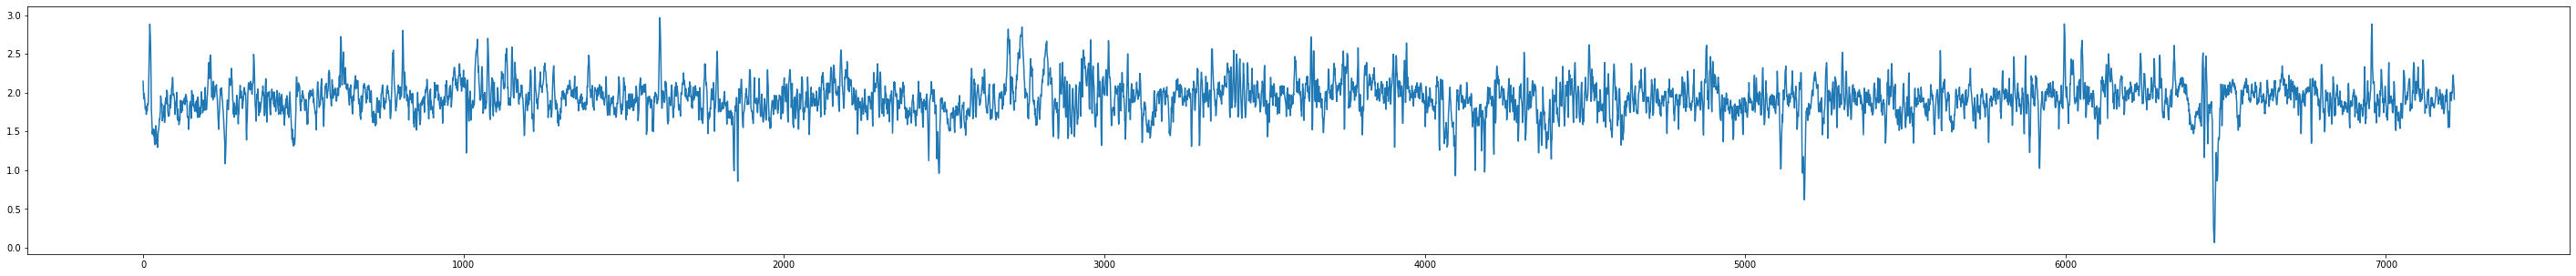

In [53]:
plt.figure(figsize=(50,5))
plt.plot(x.data.numpy()[0])
plt.show()